Local volatility under rough volatility

# 1. Imports

In [48]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [176]:
import matplotlib.pyplot as plt
from rbergomi import RoughBergomi
import numpy as np
import utils
from scipy import stats, integrate
import time

# sns.set_theme("notebook")
# plt.style.use("seaborn-v0_8-whitegrid")
plt.style.use("ggplot")

In [28]:
# Set model parameters and create three instances of Rough Bergomi model with
# H = 0.1, 0.3, and 0.5

list_H = [0.1, 0.3, 0.5]

params = {
    "s0": 1.0,
    "xi0": lambda u: np.ones_like(u) * 0.235**2,
    "eta": 1.0,
    "rho": -0.7,
}

rbergomi_models = {f"H={H}": RoughBergomi(**params, H=H) for H in list_H}

In [77]:
colors = {0.1: "blue", 0.3: "green", 0.5: "red"}
markers = {0.1: ".", 0.3: "+", 0.5: "x"}
seed = 1234
maturity = 0.5
n_disc = 400
tab_t = np.linspace(0.0, maturity, n_disc + 1)
dt = tab_t[1] - tab_t[0]
n_mc = 2 * 10**5
n_loop = 1

We compute the: 

- ATM local volatility skew $\partial_k \sigma_{loc}(T,k)|_{k=0}$
- ATM implied volatility skew $\partial_k \sigma_{BS}(T,k)|_{k=0}$ 

and compare them.

In [78]:
n_disc_split = 50

atm_impvols = {}
atm_impvol_skews = {}
atm_lvs = {}
atm_lv_skews = {}

for H in list_H:
    t0 = time.time()
    print("H =", H)
    res = rbergomi_models[f"H={H}"].atm_implied_vol_local_vol_skew(
        tab_t=tab_t, n_mc=n_mc, n_loop=n_loop, seed=seed, n_disc_split=n_disc_split
    )
    atm_impvols[f"H={H}"], atm_impvol_skews[f"H={H}"] = res[1]
    atm_lvs[f"H={H}"], atm_lv_skews[f"H={H}"] = res[2]
    print(f"time taken: {(time.time() - t0):.2f} seconds\n")

H = 0.1
iteration 1 of 1
split in 8 parts, each with 50 time steps
time taken: 17.23 seconds

H = 0.3
iteration 1 of 1
split in 8 parts, each with 50 time steps
time taken: 14.85 seconds

H = 0.5
iteration 1 of 1
split in 8 parts, each with 50 time steps
time taken: 10.43 seconds



In [79]:
tab_t_split = np.array([t[-1] for t in np.split(tab_t[1:], n_disc // n_disc_split)])

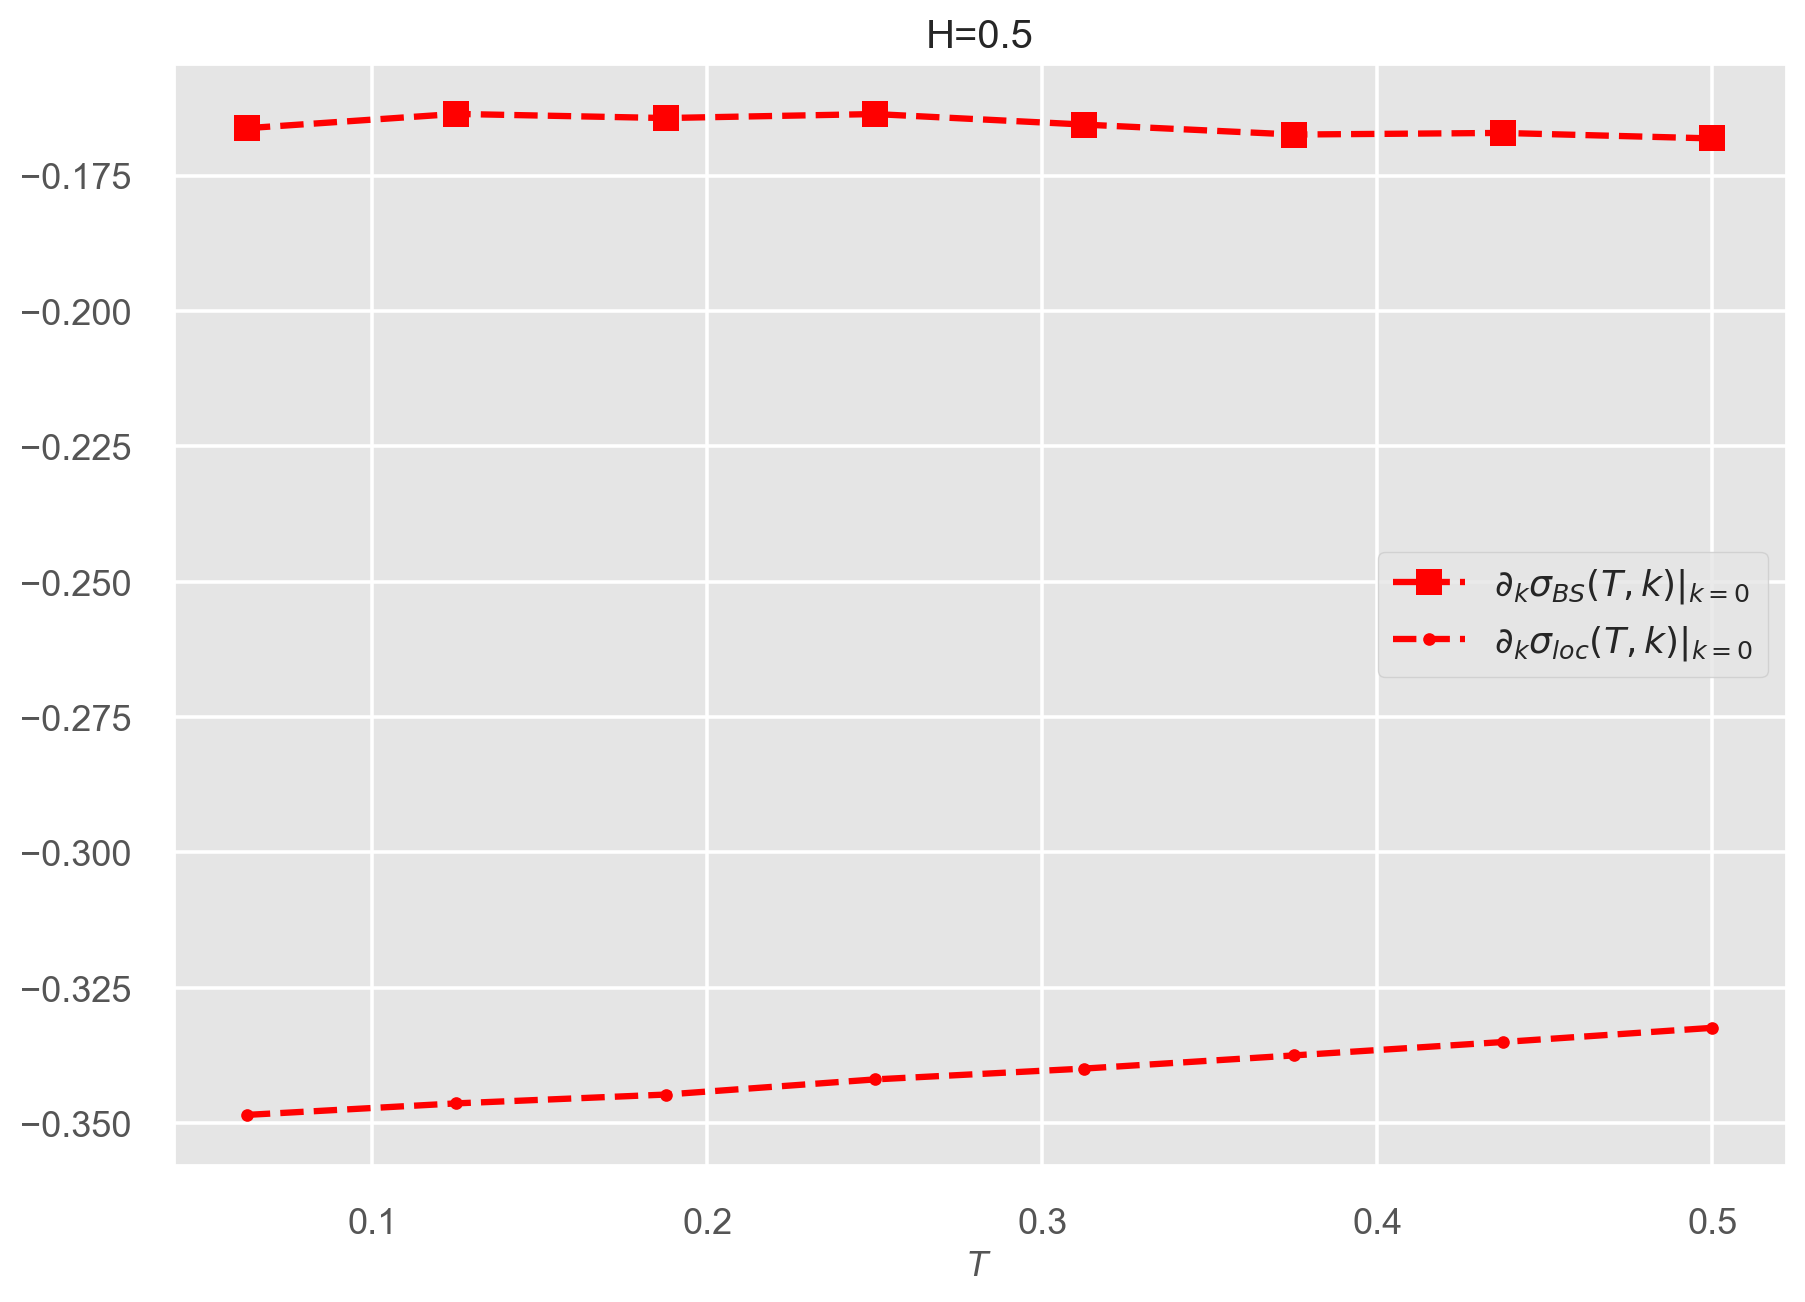

In [177]:
H = 0.5

plt.close()
fig, ax = plt.subplots()
ax.plot(
    tab_t_split,
    atm_impvol_skews[f"H={H}"],
    "--s",
    label="$\\partial_k \\sigma_{BS}(T,k)|_{k=0}$",
    color=colors[H],
)
ax.plot(
    tab_t_split,
    atm_lv_skews[f"H={H}"],
    "--.",
    label="$\\partial_k \\sigma_{loc}(T,k)|_{k=0}$",
    color=colors[H],
)
ax.set_xlabel("$T$")
# ax.set_xlim(0.0, tab_t_split[-1] * 1.05)
ax.set_title(f"H={H}")
ax.legend()
plt.show()

We want to check that 

$$
    \frac{\partial_k \sigma_{BS}(T,k)|_{k=0}}{\partial_k \sigma_{loc}(T,k)|_{k=0}}
    \underset{T\to0}{\to} \frac{1}{H+3/2}
$$

In [81]:
tab_t_split

array([0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375, 0.5   ])

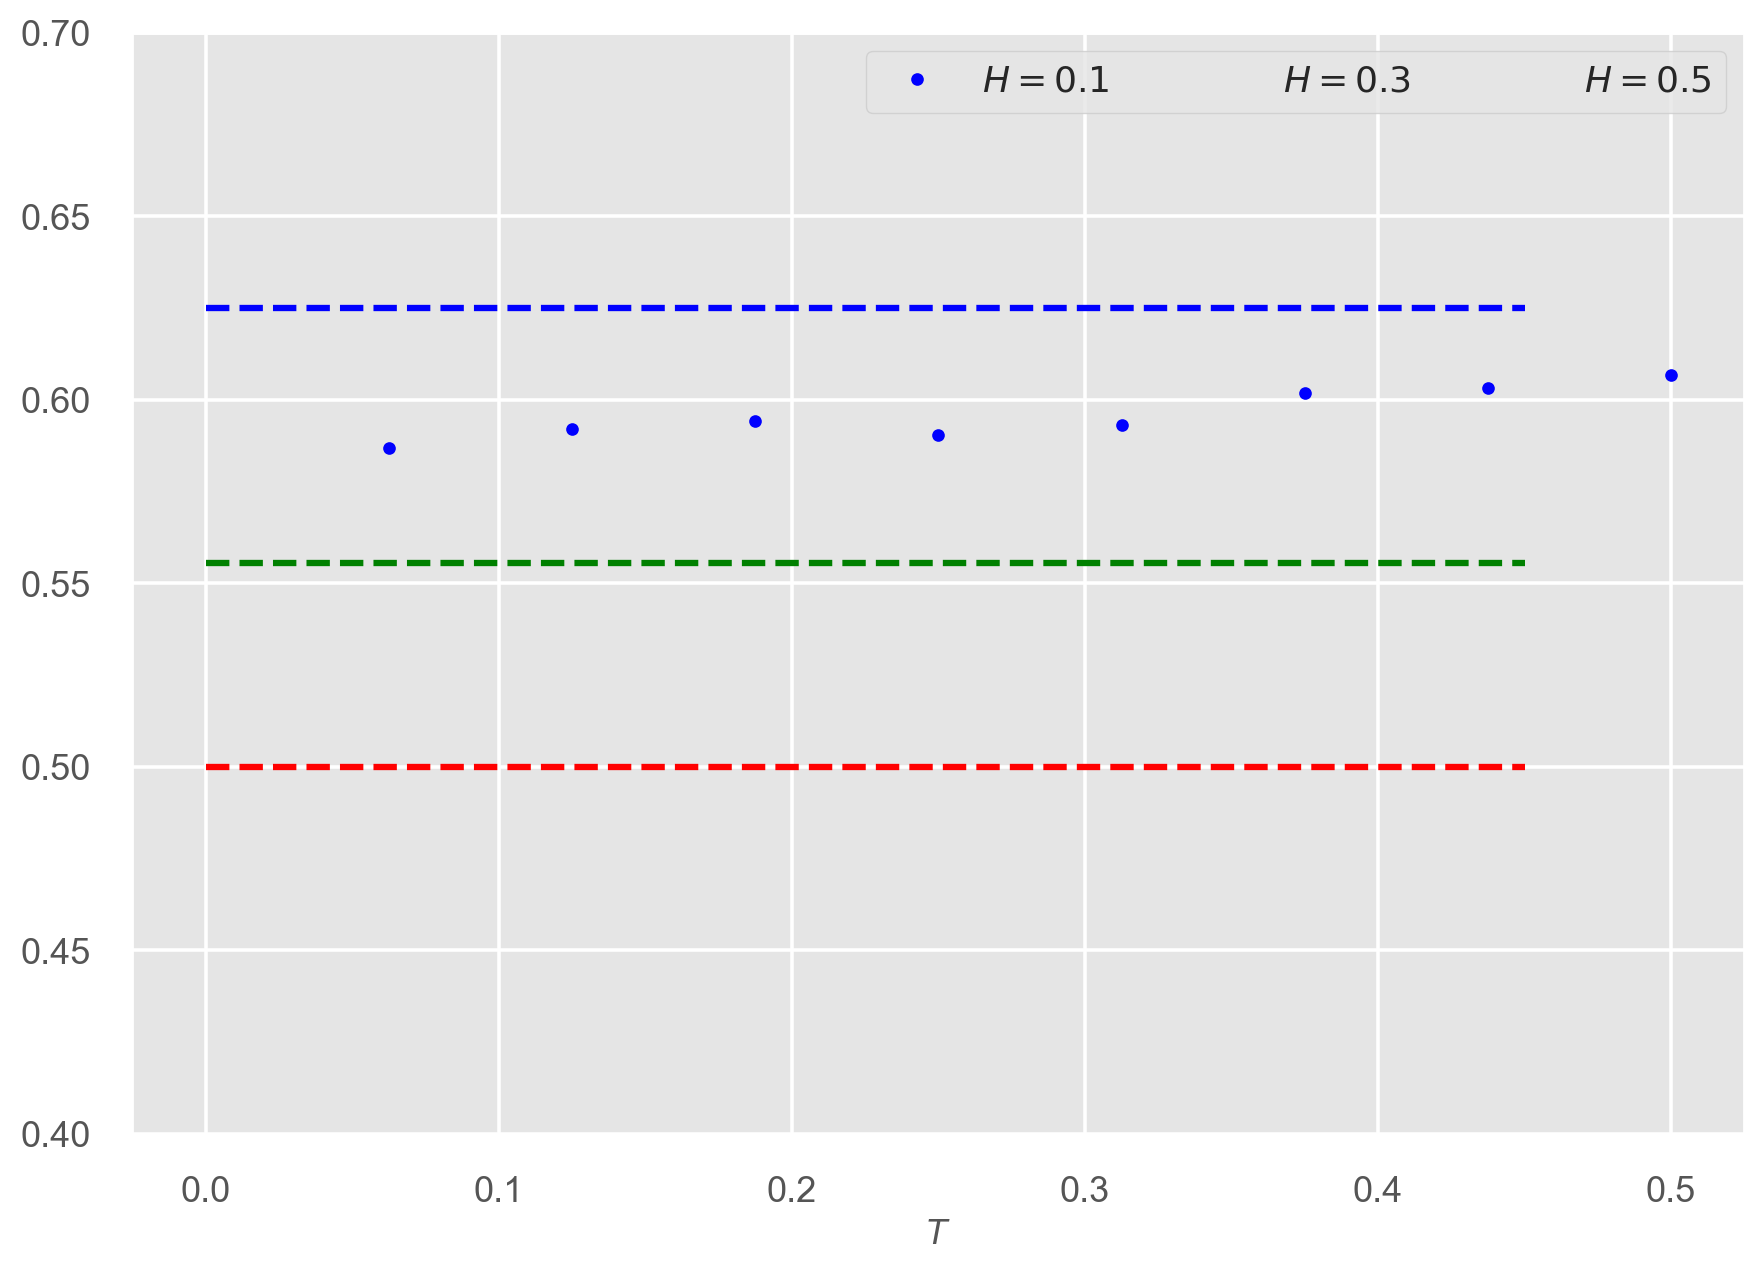

In [178]:
plt.close()
fig, ax = plt.subplots()
for H in list_H:
    ax.plot(
        tab_t_split,
        atm_impvol_skews[f"H={H}"] / atm_lv_skews[f"H={H}"],
        markers[H],
        label=f"$H={H}$",
        color=colors[H],
    )
    ax.plot(tab_t, 1.0 / (H + 1.5) * np.ones_like(tab_t), "--", color=colors[H])
ax.set_xlabel("$T$")
ax.legend(ncol=3)
ax.set_ylim(0.4, 0.7)
plt.show()

In [ ]:
# Simulate cases: H=0.1, 0.3, 0.5

We compare the implied volatility $\sigma_{BS}(T,k)$ and the harmonic mean
$H(T,k)$ of the local volatility $\sigma_{loc}(T,k)$ defined as 

$$
    H(T,k) = \left(\frac{1}{k}\int_0^k \frac{dy}{\sigma_{loc}(T,y)}\right)^{-1}
$$

In [160]:
# todo

H = 0.3
T = 0.45

tab_t = np.linspace(0.0, T, n_disc + 1)
paths = rbergomi_models[f"H={H}"].simulate(
    tab_t=tab_t, n_mc=n_mc, n_loop=n_loop, seed=seed, conditioning=True
)


def func_locvol(y):
    return rbergomi_models[f"H={H}"].local_vol_from_paths(
        k=y,
        v_t=paths["v"][-1, :],
        int_v_dt=paths["int_v_dt"],
        int_sqrt_v_dw=paths["int_sqrt_v_dw"],
    )

In [161]:
def harmonic_mean_loc_vol(k):
    if k == 0.0:
        return func_locvol(0.0)[0]
    return 1.0 / (integrate.quad(lambda y: 1.0 / func_locvol(y)[0], 0, k)[0] / k)

In [162]:
tab_k = np.linspace(-0.2, 0.05, 11)

In [163]:
harmo_means = np.array([harmonic_mean_loc_vol(k) for k in tab_k])

In [164]:
impvol = rbergomi_models[f"H={H}"].implied_vol_from_paths(
    k=tab_k,
    T=T,
    int_v_dt=paths["int_v_dt"],
    int_sqrt_v_dw=paths["int_sqrt_v_dw"],
    conditioning=True,
)

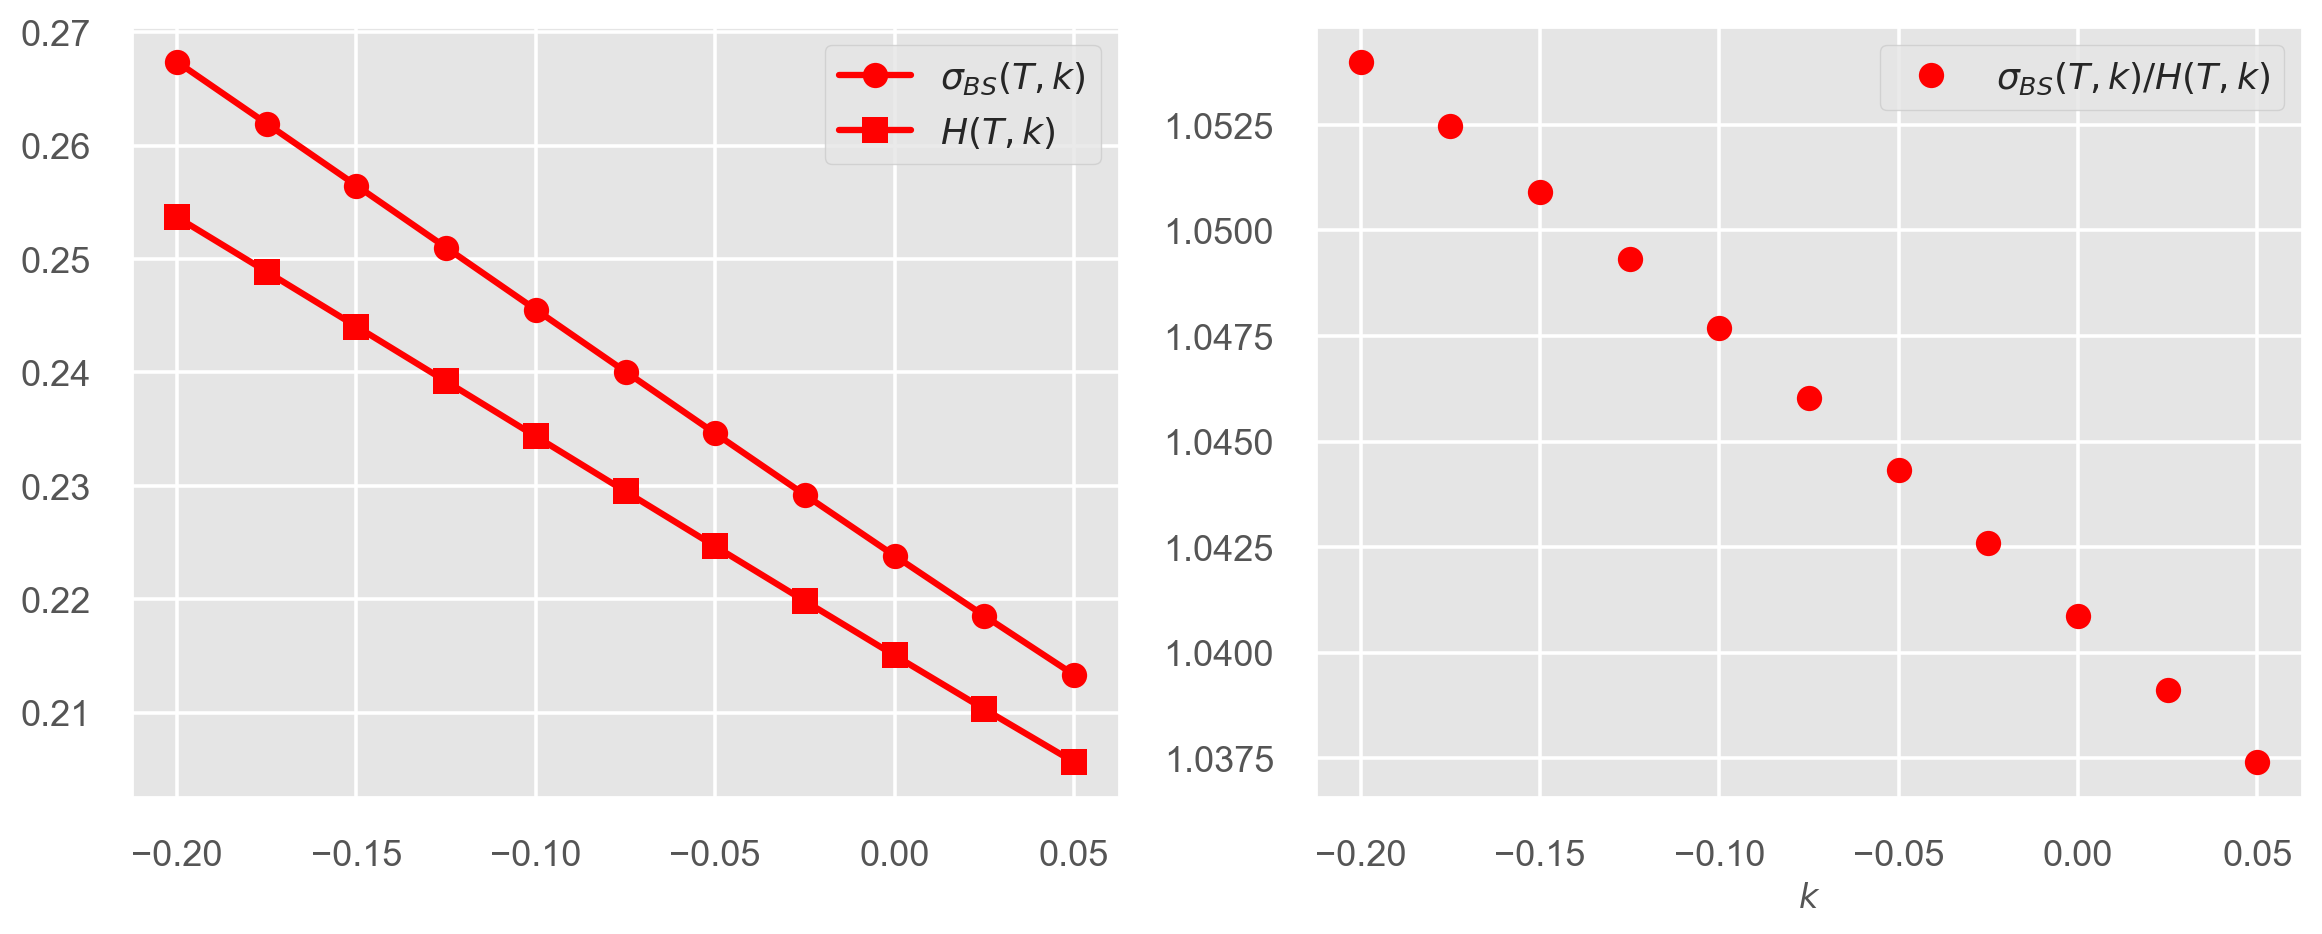

In [179]:
fig, ax = plt.subplots(1, 2, figsize=(2 * 7, 5))
ax[0].plot(tab_k, impvol, "-o", label=r"$\sigma_{BS}(T,k)$", color=colors[H])
ax[0].plot(tab_k, harmo_means, "-s", label="$H(T,k)$", color=colors[H])
ax[0].legend()
ax[1].plot(
    tab_k,
    impvol / harmo_means,
    "o",
    label=r"$\sigma_{BS}(T,k) / H(T,k)$",
    color=colors[H],
)
ax[1].set_xlabel("$k$")
ax[1].legend()
plt.show()

Comparison of $\sigma_{loc}(T,y \, T^{1/2-H})$ and $\sigma(\widehat{h_1^y})$ for 
$T \in \{0.05, 0.2, 0.35, 0.5\}$.

The rate function minimizing path $\widehat{h}_1^y$ is evaluated using the Ritz 
projection method with $N=8$ Fourier basis functions. We refer to section 
4.2. for details.

In [95]:
H = 0.3
print("H =", H, "\n")

n_mc = 1 * 10**5
n_disc = 200
n_loop = 1
y = np.linspace(-0.5, 0.5, 11)
list_T = [0.05, 0.2, 0.35, 0.5]
lv_y = np.zeros((len(list_T), y.shape[0]))

for i, T in enumerate(list_T):
    print("T =", T)
    lv_y[i, :] = rbergomi_models[f"H={H}"].local_vol(
        k=y * T ** (0.5 - H), T=T, n_mc=n_mc, n_disc=n_disc, n_loop=n_loop, seed=seed
    )

H = 0.3 

T = 0.05
T = 0.2
T = 0.35
T = 0.5


In [ ]:
n_trunc = 8
tab_a, _ = rbergomi_models[f"H={H}"].rate_function(y, N=n_trunc)

In [125]:
eta = rbergomi_models[f"H={H}"].eta
sigma_0 = rbergomi_models[f"H={H}"].xi0(0.0) ** 0.5

In [126]:
sig_h = np.array(
    [
        utils.fsigma(utils.f_hat(tab_a[i, :], 1, H), sigma_0, eta)
        for i in range(y.shape[0])
    ]
)

sig_h

array([0.49388113, 0.43041912, 0.37190462, 0.31919673, 0.27321122,
       0.235     , 0.20609184, 0.1896702 , 0.19503351, 0.25271169,
       0.38303638])

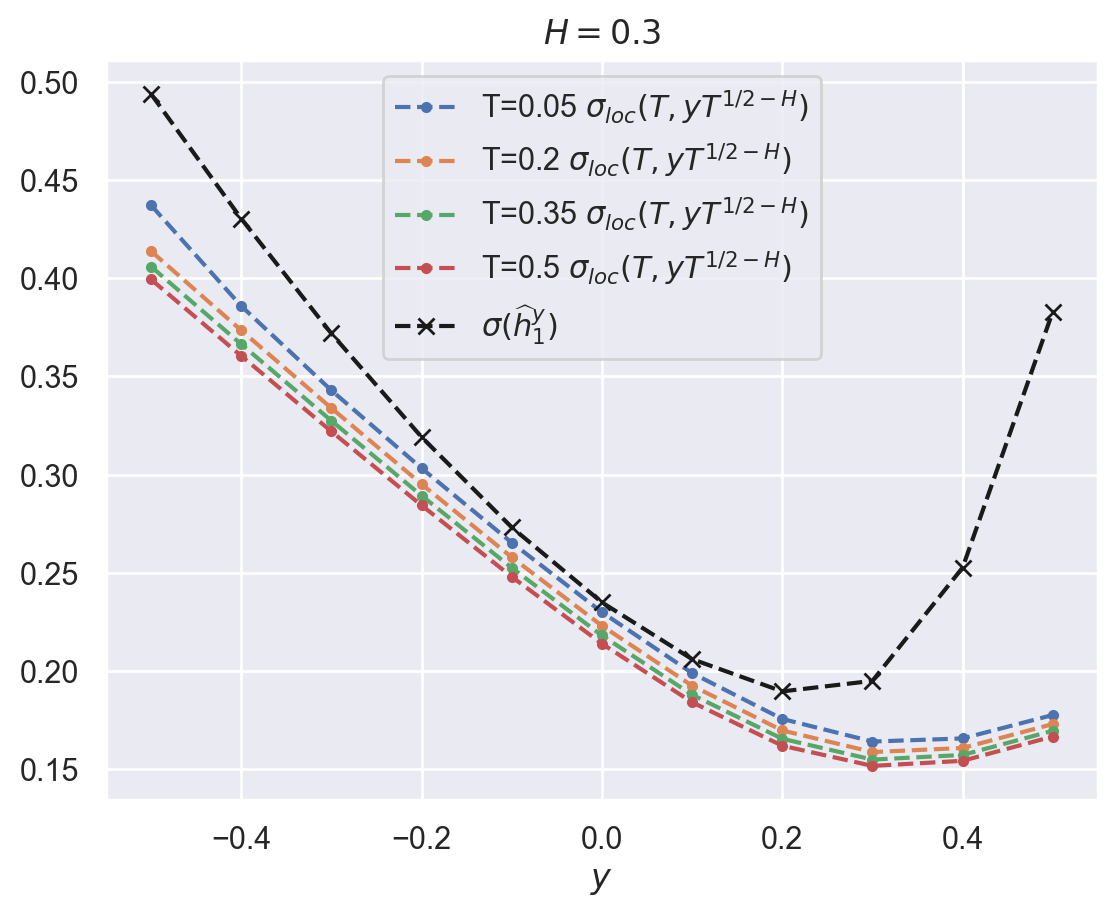

In [127]:
fig, ax = plt.subplots()
for i, T in enumerate(list_T):
    ax.plot(y, lv_y[i, :], ".--", label=f"T={T} " + r"$\sigma_{loc}(T,yT^{1/2-H})$")
ax.plot(y, sig_h, "x--k", label=r"$\sigma(\widehat{h}_1^y)$")
ax.set_xlabel("$y$")
ax.set_title(f"$H={H}$")
ax.legend()
plt.show()